# Dynamic Pricing Dataset
https://www.kaggle.com/datasets/arashnic/dynamic-pricing-dataset

About Dataset

A ride-sharing company wants to implement a dynamic pricing strategy to optimize fares based on real-time market conditions. The company only uses ride duration to decide ride fares currently. The company aims to leverage data-driven techniques to analyze historical data and develop a predictive model that can dynamically adjust prices in response to changing factors.

The dataset containing historical ride data has been provided. It includes features such as the number of riders, number of drivers, location category, customer loyalty status, number of past rides, average ratings, time of booking, vehicle type, expected ride duration, and historical cost of the rides.


#### Goal- predict price basing on provided data.

In [126]:
import kagglehub
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dython
import optuna
from optuna.pruners import HyperbandPruner
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import xgboost
import plotly.express as px
from pingouin import partial_corr

import utils

In [127]:
path = kagglehub.dataset_download("arashnic/dynamic-pricing-dataset")
src = pd.read_csv(os.path.join(path, "dynamic_pricing.csv"))
src.rename(columns={
    'Number_of_Riders': 'Riders',
    'Number_of_Drivers': 'Drivers',
    'Location_Category': 'Location',
    'Customer_Loyalty_Status': 'Loyalty',
    'Number_of_Past_Rides': 'PastRides',
    'Average_Ratings': 'Ratings',
    'Time_of_Booking': 'BookingTime',
    'Vehicle_Type': 'Vehicle',
    'Expected_Ride_Duration': 'Duration',
    'Historical_Cost_of_Ride': 'Cost'
}, inplace=True)

In [156]:
print(src.head())

   Riders   Drivers  Location  Loyalty  PastRides  BookingTime  Vehicle  \
0      90  4.494508         2        2         13            3        1   
1      58  4.297948         1        2         72            1        0   
2      42  3.987560         0        2          0            0        1   
3      89  3.851875         0        1         67            0        1   
4      78  3.535029         0        1         74            0        0   

     Duration        Cost  Riders_per_Driver  PCA_Rider_Driver  \
0  349.998111  284.257273          20.024438          1.613809   
1  239.681871  173.874753          13.494812          0.515046   
2  317.137954  329.795469          10.532756         -0.189298   
3  453.272888  470.201232          23.105633          1.114464   
4  488.480198  579.681422          22.064880          0.554647   

   PCA_Duration_Cost  
0          -0.471533  
1          -1.565080  
2          -0.500850  
3           0.864469  
4           1.494145  


In [128]:
print(f"Dataset info:\n"
      f"shape: \n{src.shape}\n"
      f"null values: \n{src.isnull().sum()}\n"
      f"dtypes: \n{src.dtypes}")


Dataset info:
shape: 
(1000, 10)
null values: 
Riders         0
Drivers        0
Location       0
Loyalty        0
PastRides      0
Ratings        0
BookingTime    0
Vehicle        0
Duration       0
Cost           0
dtype: int64
dtypes: 
Riders           int64
Drivers          int64
Location        object
Loyalty         object
PastRides        int64
Ratings        float64
BookingTime     object
Vehicle         object
Duration         int64
Cost           float64
dtype: object


OK, so 1000 entries, no null values. Good.
Let's create base model to have reference point.

In [129]:
num_cols = src.select_dtypes(include=['float64', 'int']).columns.values.tolist()
cat_cols = src.select_dtypes(include=['object']).columns.values.tolist()

def base_model(df: pd.DataFrame):
    encoder = LabelEncoder()
    for cat in src[src.columns[src.dtypes == 'object']]:
        df[cat] = encoder.fit_transform(df[cat])

    base_model = xgboost.XGBRegressor()
    X = src.drop(columns=['Cost']).to_numpy()
    y = src['Cost'].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    base_model.fit(X_train, y_train)
    y_pred = base_model.predict(X_test)

    base_score = base_model.score(X_test, y_test)
    base_rmse = root_mean_squared_error(y_test, y_pred)

    print("R squared: ", base_score)
    print("RMSE:", base_rmse)

    feature_importances = base_model.feature_importances_

    print("Feature importances:")
    for feature_name, importance in zip(src.drop(columns=['Cost']).columns.values, feature_importances):
        print(f"Feature: {feature_name}, Importance: {importance}")

    return feature_importances

base_model_fi = base_model(src)

R squared:  0.8376721994853837
RMSE: 76.93245052536675
Feature importances:
Feature: Riders, Importance: 0.012547303922474384
Feature: Drivers, Importance: 0.019182195886969566
Feature: Location, Importance: 0.018554596230387688
Feature: Loyalty, Importance: 0.017915029078722
Feature: PastRides, Importance: 0.020553501322865486
Feature: Ratings, Importance: 0.02504001371562481
Feature: BookingTime, Importance: 0.016983777284622192
Feature: Vehicle, Importance: 0.06614096462726593
Feature: Duration, Importance: 0.8030825853347778


Good R squared metric, bu RMSE is quite off. Also, Duration has few times higher impact on price than
any other feature. Let's check correlation plot and see why.
Since we have mix of numerical and categorical variables,
standard data.corr() won't work here. We will use Dython package instead.

citation from website http://shakedzy.xyz/dython/: "Given a dataset, Dython will automatically find which features are categorical and which are numerical, compute a relevant measure of association between each and every feature, and plot it all as an easy-to-read heat-map."

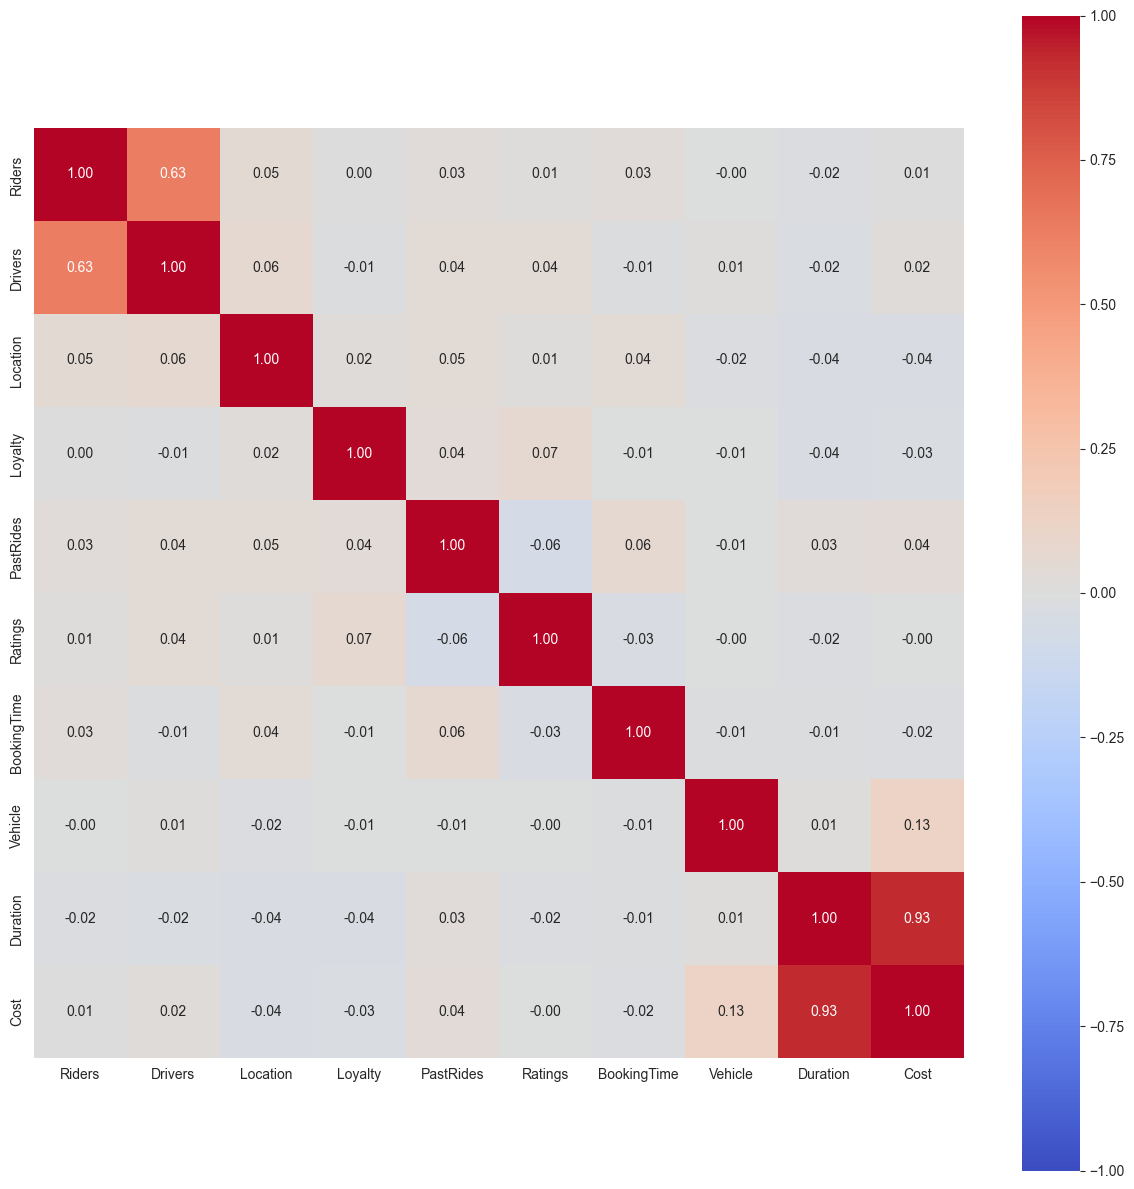

{'corr':                Riders   Drivers  Location   Loyalty  PastRides   Ratings  \
 Riders       1.000000  0.627016  0.050596  0.002304   0.029265  0.008572   
 Drivers      0.627016  1.000000  0.064874 -0.012505   0.039660  0.041204   
 Location     0.050596  0.064874  1.000000  0.018074   0.046330  0.009200   
 Loyalty      0.002304 -0.012505  0.018074  1.000000   0.035519  0.067968   
 PastRides    0.029265  0.039660  0.046330  0.035519   1.000000 -0.064734   
 Ratings      0.008572  0.041204  0.009200  0.067968  -0.064734  1.000000   
 BookingTime  0.026725 -0.011344  0.040890 -0.007217   0.064281 -0.033306   
 Vehicle     -0.002635  0.014845 -0.017770 -0.005323  -0.005615 -0.002523   
 Duration    -0.015856 -0.024418 -0.035920 -0.038945   0.030679 -0.016968   
 Cost         0.005826  0.017082 -0.035874 -0.030553   0.035859 -0.001063   
 
              BookingTime   Vehicle  Duration      Cost  
 Riders          0.026725 -0.002635 -0.015856  0.005826  
 Drivers        -0.011344  

In [130]:
# Good R squared metric, bu RMSE is quite off. Also, Duration has few times higher impact on price than
# any other feature. Let's check correlation plot and see why.
# Since we have mix of numerical and categorical variables,
# standard data.corr() won't work here. We will use dython.nominal.associations instead.
initial_corr_matrix = dython.nominal.associations(src, plot=True, cmap='coolwarm')
initial_corr_matrix

So as we see, cause of so high feature importance for Duration is fact that it is very highly correlated with Duration.
We will need to do regularization to it.
Unfortunatelly, other features are very loosly correlated with prices.
Let's first drop Ratings, since it has 0 correlation with Price.

In [131]:
src.drop(columns=['Ratings'], inplace=True)
num_cols.remove('Ratings')
num_cols

['Riders', 'Drivers', 'PastRides', 'Duration', 'Cost']

Let's do some more plots.

First, let's see distributions of numerical columns. We'll use KDE plots for this.

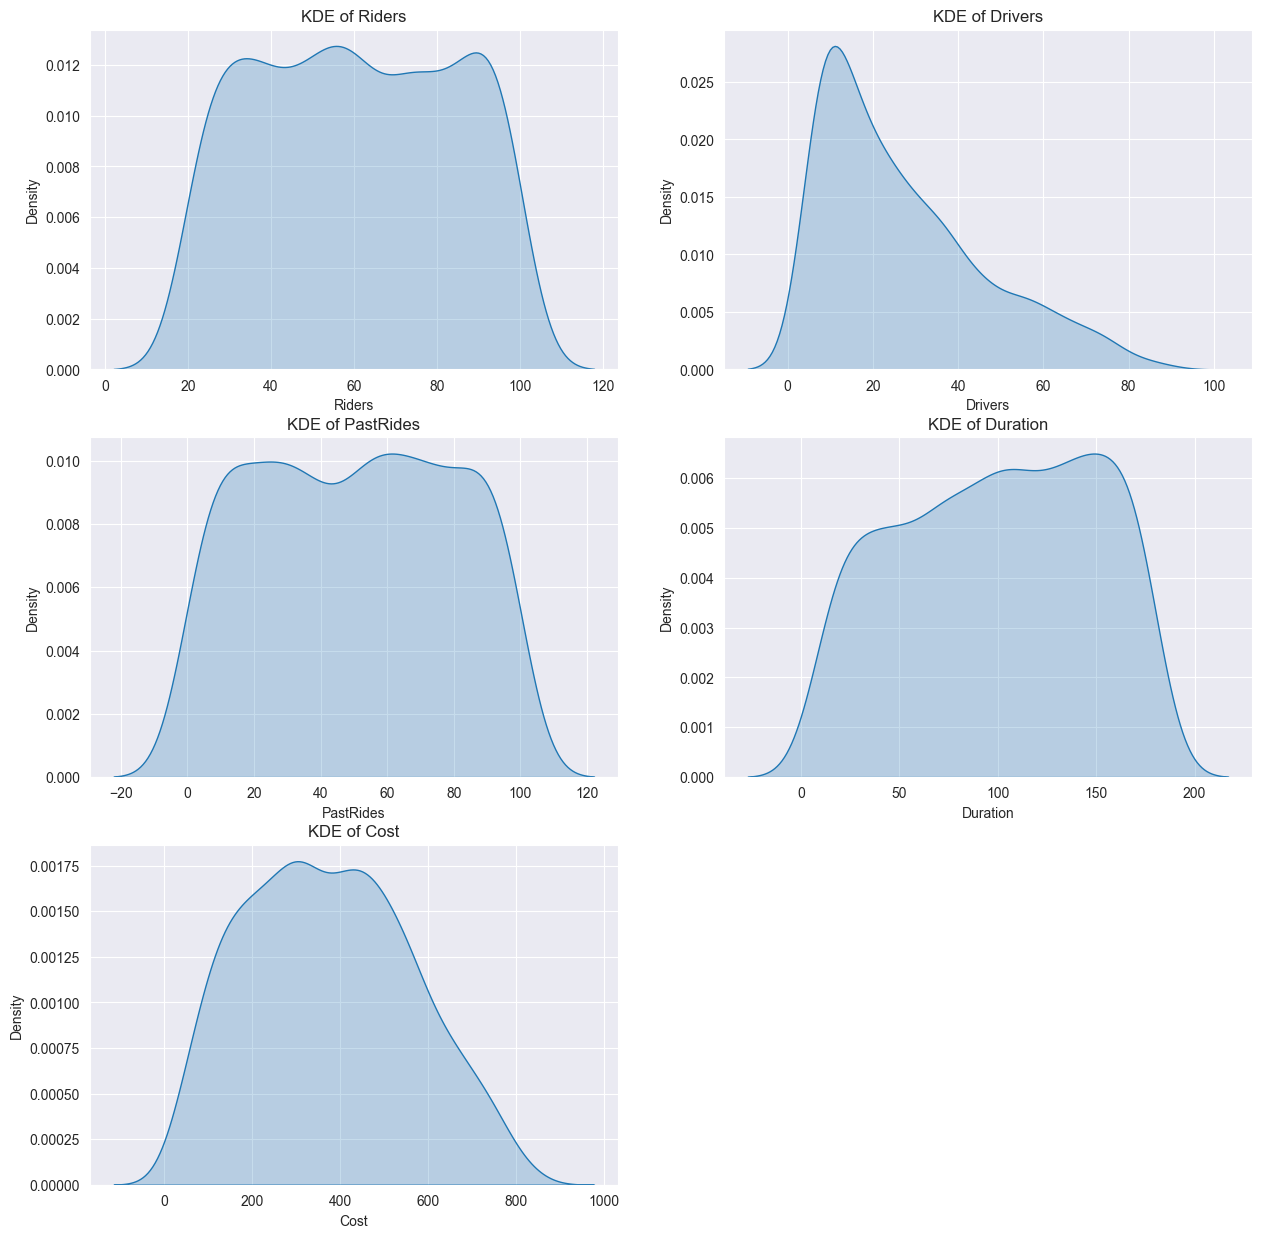

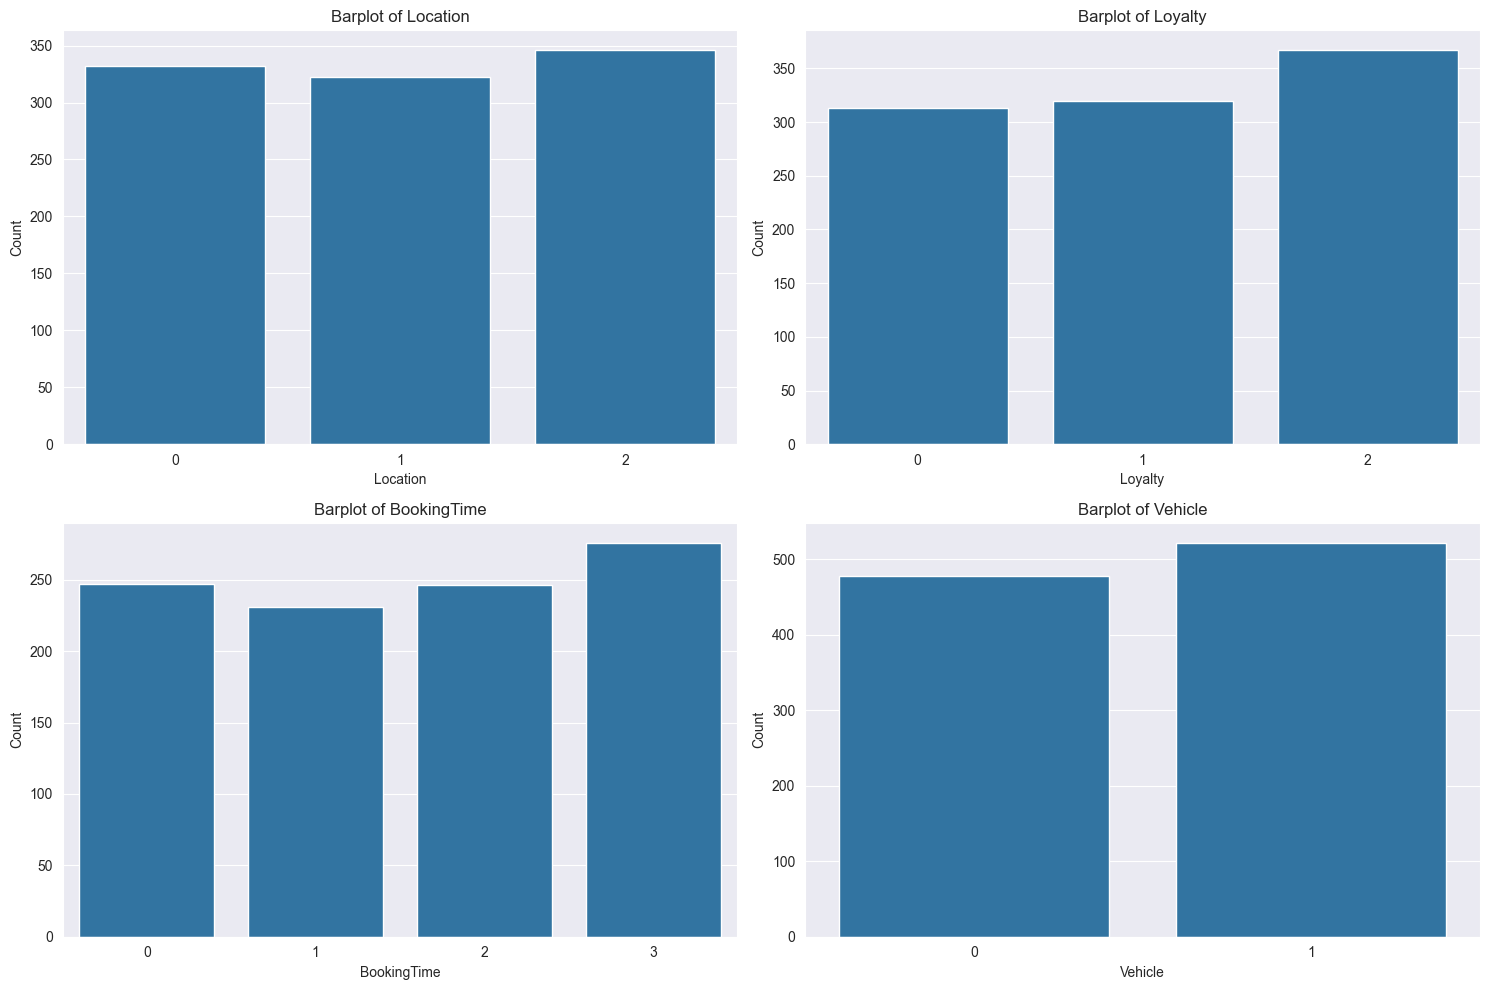

In [132]:
# Numerical plots- KDE Plots
# Calculate number of rows needed to fit two plots per row
n_rows = (len(num_cols) + 1) // 2
# Create subplots with 2 plots in 1 row
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

for col, ax in zip(num_cols, axes):
    sns.kdeplot(data=src, x=col, ax=ax, fill=True)
    ax.set_title(f'KDE of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')

# Hide any unused subplots
for ax in axes[len(num_cols):]:
    ax.axis('off')


# Categorical plots- Bar plots
n_rows = (len(cat_cols) + 1) // 2
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

for col, ax in zip(cat_cols, axes):
    sns.countplot(data=src, x=col, ax=ax)
    ax.set_title(f'Barplot of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

# Hide any unused subplots
for ax in axes[len(cat_cols):]:
    ax.axis('off')

# Adjusting layout to prevent overlap
plt.tight_layout()
plt.show()

In [133]:
# Calculate skewness of numerical columns
skewness = src[num_cols].skew()
print("Skewness of numerical columns:\n", skewness)
print()
# And calculate imbalance ratios for categorical columns
for cat in cat_cols:
    cat_imbalance = src[cat].value_counts(normalize=True)
    imbalance_ratio = cat_imbalance.max() / cat_imbalance.min()
    print(f"Imbalance ratio of {cat}: {imbalance_ratio:.2f}")

Skewness of numerical columns:
 Riders       0.002167
Drivers      0.963204
PastRides   -0.008457
Duration    -0.139868
Cost         0.209580
dtype: float64

Imbalance ratio of Location: 1.07
Imbalance ratio of Loyalty: 1.17
Imbalance ratio of BookingTime: 1.19
Imbalance ratio of Vehicle: 1.09


We see that calculated ratio Drivers column has significant skeweness, we will do Box-Cox transformation on it.

Thankfully, data in categorical columns lookes balanced, so that's good.

so let's do transformation on box-cox and regularize Duration with ElasticNet

In [134]:
from scipy import stats
from sklearn.linear_model import ElasticNet

# Box-Cox transformation for the 'Drivers' column
src['Drivers'], _ = stats.boxcox(src['Drivers'])

# Regularize the 'Duration' column
scaler = StandardScaler()
src['Duration'] = scaler.fit_transform(src[['Duration']])

# ElasticNet regularization for duration
elasticnet_model = ElasticNet(alpha=1.0, l1_ratio=0.5)  # Adjust l1_ratio as needed
X = src[['Duration']]  # Using Duration as a single feature for regularization
y = src['Cost']
elasticnet_model.fit(X, y)
src['Duration'] = elasticnet_model.predict(X)

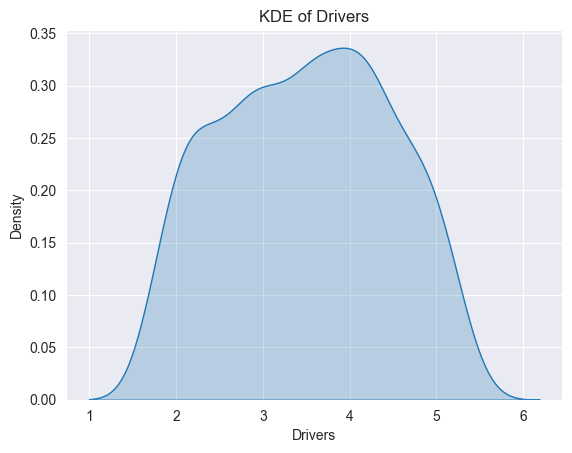

In [135]:
sns.kdeplot(data=src, x='Drivers', fill=True)
plt.title('KDE of Drivers')
plt.xlabel('Drivers')
plt.ylabel('Density')
plt.show()

In [136]:
scaler = StandardScaler()
riders_drivers_scaled = scaler.fit_transform(src[['Riders', 'Drivers']])
duration_cost_scaled = scaler.fit_transform(src[['Duration', 'Cost']])

# Calculate riders/drivers and add as a new feature
src['Riders_per_Driver'] = src['Riders'] / src['Drivers']

# Perform PCA on scaled Riders and Drivers
pca = PCA(n_components=1)
src['PCA_Rider_Driver'] = pca.fit_transform(riders_drivers_scaled)
src['PCA_Duration_Cost'] = pca.fit_transform(duration_cost_scaled)

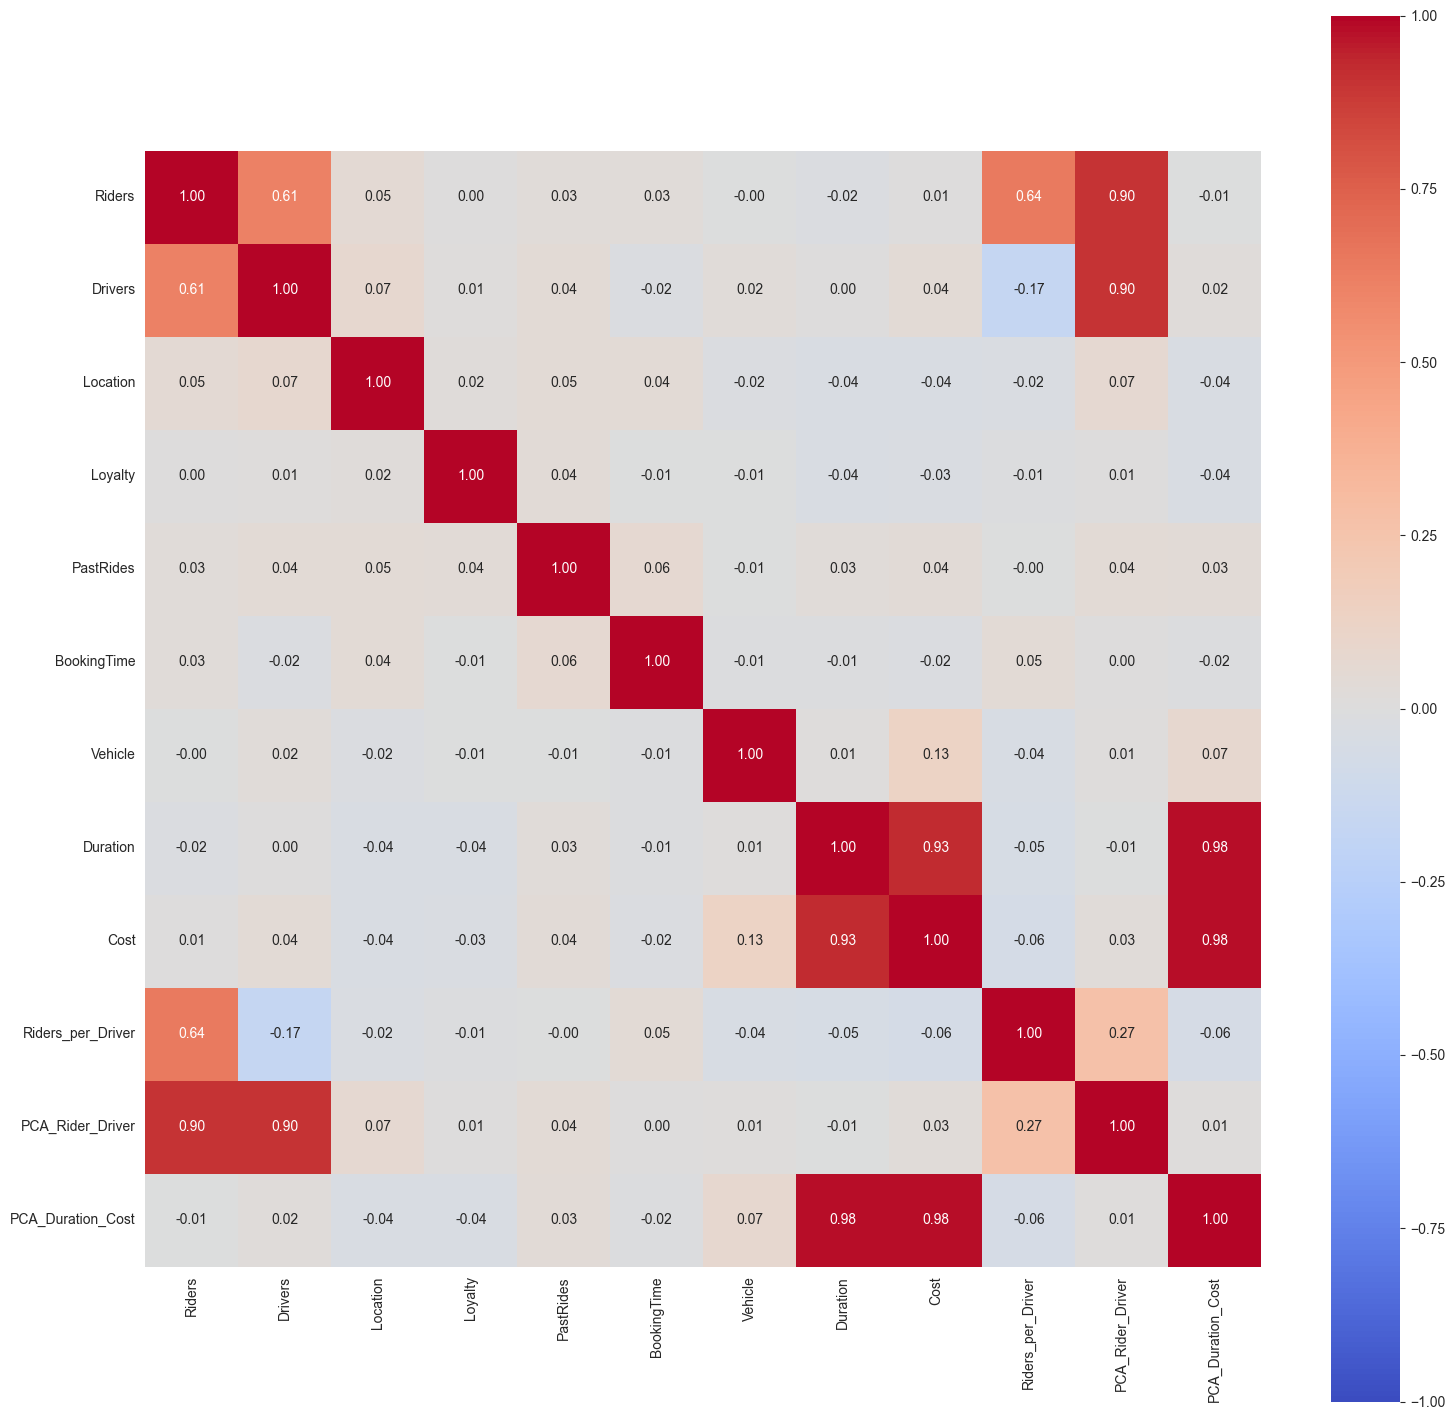

In [137]:

dython.nominal.associations(src, plot=True, cmap='coolwarm')
plt.show()

In [138]:

result = partial_corr(data=src, x='Riders_per_Driver', y='Cost', covar=['Duration'])
print(result)

            n         r          CI95%     p-val
pearson  1000 -0.049613  [-0.11, 0.01]  0.117088


In [139]:
def vif():
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    X = src[['Riders_per_Driver', 'PCA_Rider_Driver', 'Cost', 'Duration']]
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif_data)

vif()

             feature        VIF
0  Riders_per_Driver   5.943229
1   PCA_Rider_Driver   1.080706
2               Cost  27.248140
3           Duration  41.388217


In [140]:
print(src.columns)

Index(['Riders', 'Drivers', 'Location', 'Loyalty', 'PastRides', 'BookingTime',
       'Vehicle', 'Duration', 'Cost', 'Riders_per_Driver', 'PCA_Rider_Driver',
       'PCA_Duration_Cost'],
      dtype='object')


In [158]:
# Check available columns in the src DataFrame+
# Ensure that these are the correct column names
columns_to_drop = ['Cost', 'PCA_Duration_Cost', 'Riders', 'Drivers', 'Riders_Per_Driver']
available_columns = src.columns

# Filter out columns to drop that aren't present
correct_columns_to_drop = [col for col in columns_to_drop if col in available_columns]

# Drop the correct columns
X = src.drop(correct_columns_to_drop, axis=1)
y = src['Cost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb2 = xgboost.XGBRegressor()
xgb2.fit(X_train, y_train)
xgb2_y_pred = xgb2.predict(X_test)
xgb2_score = xgb2.score(X_test, y_test)
xgb2_fi = xgb2.feature_importances_

# Assuming X is your DataFrame or array used to train the model
feature_names = X.columns.values

# Create a DataFrame to map feature names with their importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb2_fi
})

# Sort the DataFrame by importance (optional)
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Display the feature importances
print(feature_importance_df)

In [161]:
def objective(trial: optuna.Trial) -> float:
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 13),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
    }

    # DMatrix for Cross Validation
    dtrain = xgboost.DMatrix(X, label=y)

    # Perform cross-validation with all parameters
    cv_results = xgboost.cv(
        dtrain=dtrain,
        params=params,  # Use all parameters here
        num_boost_round=params['n_estimators'],
        nfold=5,
        early_stopping_rounds=50,
        metrics="rmse",
        seed=42
    )

    # Extract the best score
    best_rmse = cv_results['test-rmse-mean'].min()
    return best_rmse

# Start Optuna Study
study = optuna.create_study(direction='minimize', pruner=HyperbandPruner(
    min_resource=1, max_resource=100, reduction_factor=3
))
study.optimize(objective, n_trials=200, timeout=300)

print('Best trial parameters: ', study.best_trial.params)
print('Best RMSE: ', study.best_value)

[I 2024-12-07 15:25:51,837] A new study created in memory with name: no-name-91aba105-502c-4a20-9b6e-4e7eb9d29107
C:\Program Files\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:25:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.


[I 2024-12-07 15:25:52,092] Trial 0 finished with value: 69.47033318844281 and parameters: {'n_estimators': 653, 'max_depth': 4, 'learning_rate': 0.1931539747197742, 'subsample': 0.5899943323687196, 'gamma': 1.2782154006169577, 'reg_alpha': 4.218092648010089}. Best is trial 0 with value: 69.47033318844281.
C:\Program Files\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:25:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.


Best trial parameters:  {'n_estimators': 327, 'max_depth': 3, 'learning_rate': 0.10896716368528495, 'subsample': 0.631139030160196, 'gamma': 3.1436065646103395, 'reg_alpha': 3.524912359064955}
Best RMSE:  67.65628228719575


In [142]:
import optuna.visualization as optuna_plots
optuna.visualization.plot_param_importances(study)

Zgodnie z przewidywaniami, Learning rate ma zdecydowanie największy wpływ

In [162]:
optuna_plots.plot_optimization_history(study)

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [164]:
best_params = study.best_trial.params
xgb_optimal = xgboost.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    gamma=best_params['gamma'],
    reg_alpha=best_params['reg_alpha']
)

xgb_optimal.fit(X_train, y_train)
xgb_optimal.predict(X_test)
# Correct the score method to use the test labels
xgb_optimal.score(X_test, y_test)

print(X.columns)
print('optimized feature importances: ', xgb_optimal.feature_importances_)


Index(['Location', 'Loyalty', 'PastRides', 'BookingTime', 'Vehicle',
       'Duration', 'Riders_per_Driver', 'PCA_Rider_Driver'],
      dtype='object')
optimized feature importances:  [0.06053453 0.04489988 0.04987479 0.04461149 0.11249597 0.59130454
 0.04839573 0.04788307]


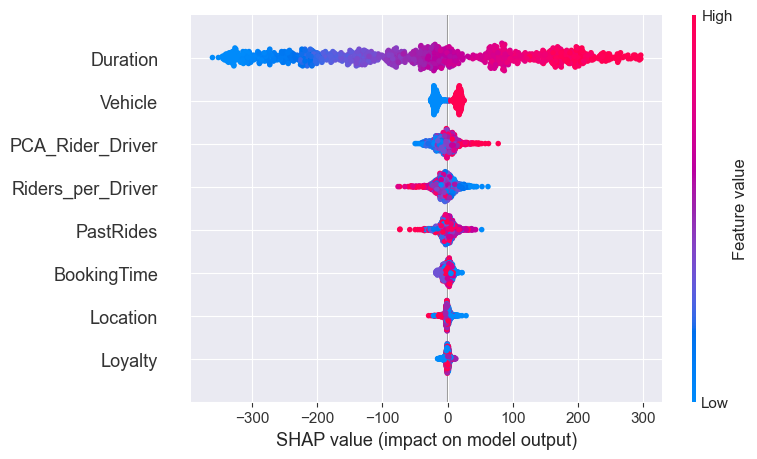

In [165]:
import shap

# Create a SHAP explainer using the trained XGBoost model
explainer = shap.Explainer(xgb_optimal, X)

# Calculate SHAP values for the dataset
shap_values = explainer(X)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

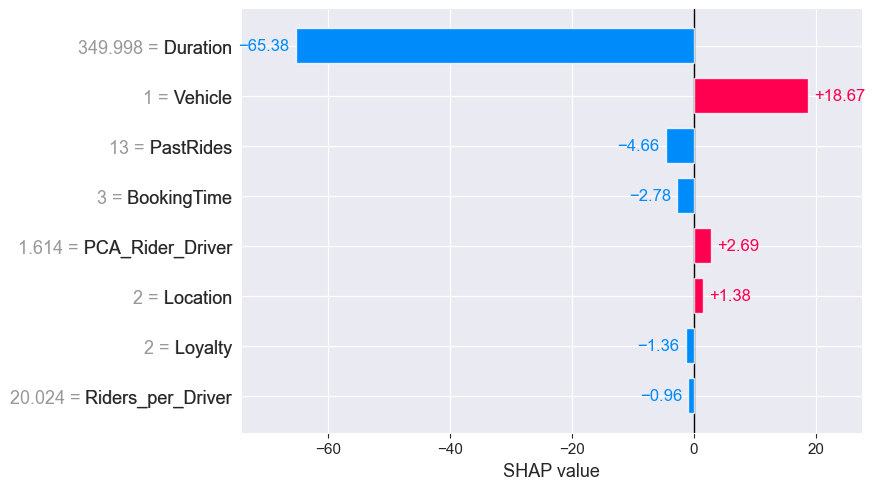

In [167]:
import shap
# Plot a SHAP waterfall plot for the first sample in the test set
shap.plots.bar(shap_values[0])

In [160]:
import plotly.express as px
import pandas as pd

# Prepare data for plotting
features = X.columns.values
importances_before_optimization = xgb2_fi
optimized_importances = xgb_optimal.feature_importances_

# Create a DataFrame for easy plotting
importances_df = pd.DataFrame({
    'Feature': features,
    'Original Importance': importances_before_optimization,
    'Optimized Importance': optimized_importances
})

# Plotting using plotly
fig = px.bar(importances_df, x='Feature', y=['Original Importance', 'Optimized Importance'],
             title='Feature Importances: Original vs Optimized',
             labels={'value': 'Importance', 'Feature': 'Feature'},
             barmode='group')

fig.show()

# Future work: Exploring additional model improvement possibilities
Let's try to improve our model. We will try to find to determine destination of ride (is it going to urban area? or rual?) Such prediction would be helpful when optimizing usage of cabs- penalizing when he is going for a long ride to rual area, and lowering a rate when coming back to town etc.

# For prototype see ride_direction_precition.py
